<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/RateDistortionOptimizedAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 2.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

In [3]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

In [4]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

In [5]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)

In [6]:
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [14]:
import requests
import os

# Replace 'YOUR_ACCESS_KEY' with your actual Unsplash access key
access_key = 'YOUR_ACCESS_KEY'

# Specify the query and number of images to download
query = 'nature'
num_images = 5

# Set up the API endpoint and parameters
api_url = f'https://api.unsplash.com/photos/random'
params = {
    'client_id': access_key,
    'query': query,
    'count': num_images
}

# Make the API request
response = requests.get(api_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Create a directory to save the downloaded images
    os.makedirs(query, exist_ok=True)

    # Download and save each image
    for i, photo in enumerate(data):
        photo_url = photo['urls']['regular']
        image_data = requests.get(photo_url).content
        with open(os.path.join(query, f'image_{i+1}.jpg'), 'wb') as f:
            f.write(image_data)

    print(f'{num_images} images downloaded successfully.')
else:
    print(f'Error: {response.status_code}')
    print(response.text)


Error: 401
{"errors":["OAuth error: The access token is invalid"]}


In [13]:
import requests

# Specify the synset ID for the category you are interested in
synset_id = "n02319095"  # Example: Persian cat

# Specify the number of images to download
num_images = 10

# ImageNet API URL
api_url = f"http://www.image-net.org/api/text/imagenet.synset.geturls?wnid={synset_id}"

# Make a request to get a list of image URLs
response = requests.get(api_url)
image_urls = response.text.splitlines()[:num_images]

# Download images
for i, url in enumerate(image_urls):
    response = requests.get(url)
    with open(f"image_{i+1}.jpg", "wb") as f:
        f.write(response.content)

MissingSchema: ignored

In [10]:
%%bash
mkdir dataset
cd dataset
mkdir train
cd train


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = datagen.flow_from_directory(
    'dataset/train',
    target_size=(height, width),  # specify image dimensions
    batch_size=batch_size,
    class_mode='input',  # Use 'input' for autoencoder
    shuffle=True
)

In [7]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [8]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 218.3849 - distortion_loss: 0.0592 - rate_loss: 100.0275 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 100.0232

469/469 [==============================] - 24s 21ms/step - loss: 218.3849 - distortion_loss: 0.0592 - rate_loss: 100.0275 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 100.0232 - val_loss: 178.2684 - val_distortion_loss: 0.0431 - val_rate_loss: 92.1145 - val_distortion_pass_through_loss: 0.0431 - val_rate_pass_through_loss: 92.1150
Epoch 2/15
469/469 [==============================] - 4s 9ms/step - loss: 166.9728 - distortion_loss: 0.0415 - rate_loss: 83.9415 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 83.9373 - val_loss: 157.3902 - val_distortion_loss: 0.0409 - val_rate_loss: 75.6272 - val_distortion_pass_through_loss: 0.0409 - val_rate_pass_through_loss: 75.6361
Epoch 3/15
469/469 [==============================] - 6s 14ms/step - loss: 151.6930 - distortion_loss: 0.0403 - rate_loss: 71.1513 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 71.1485 - val_loss: 145.4678 - val_distortion_loss: 0.0402 - val_rate_loss: 65.0480 - val_d

In [9]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

In [10]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

In [11]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)

String representation of first digit in hexadecimal: 0x842d0dd4
Number of bits actually needed to represent it: 34.19


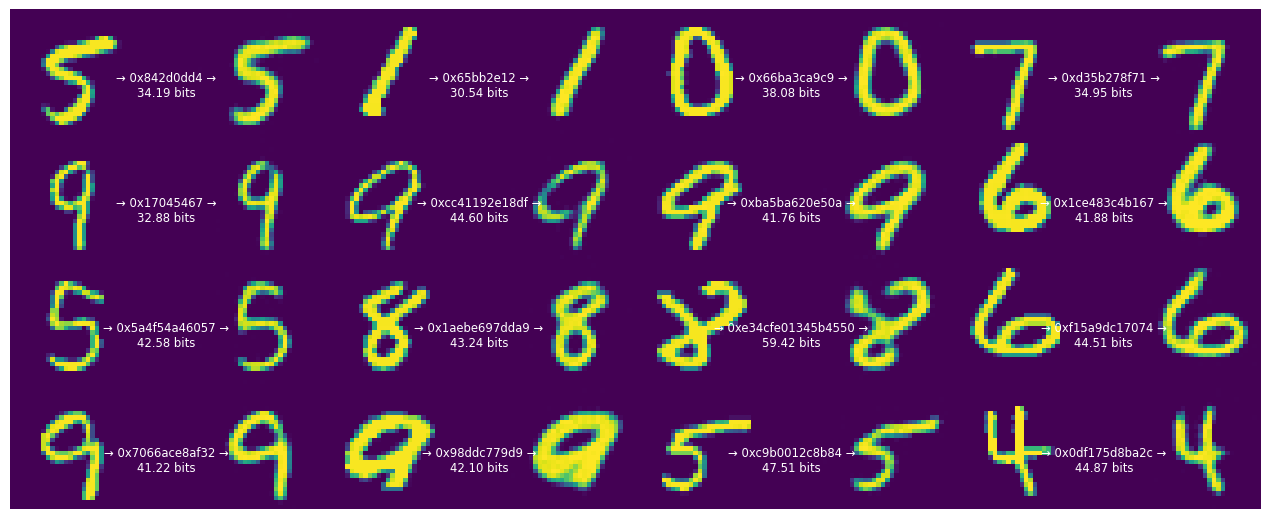

In [12]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

reconstructions = decompressor(strings)

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

display_digits(originals, strings, entropies, reconstructions)
